# PART 3: Exploratory Analysis (incl. Feature Engineering)

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import sentiment_analyzer, vader, SentimentAnalyzer, SentimentIntensityAnalyzer
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from transformers import pipeline
import spacy
import scattertext as st
from IPython.display import IFrame
from IPython.core.display import display, HTML
import emoji

%config InlineBackend.figure_format = 'retina';

#### Retrieving data harvested in step 1 and cleaned in step 2 from csv files to dataframes

In [2]:
AW_comments_df = pd.read_csv('../data/aw_com.csv')
AW_posts_df = pd.read_csv('../data/aw_pos.csv')
AM_comments_df = pd.read_csv('../data/am_com.csv')
AM_posts_df = pd.read_csv('../data/am_pos.csv')

### 3.1 Analysis of length of posts and comments

In [3]:
AM_posts_df['len_chars'] = AM_posts_df['title_selftext'].apply(lambda x: len(str(x)))
AM_posts_df['len_words'] = AM_posts_df['title_selftext'].apply(lambda x: str(x).count(' '))
AM_posts_df['avg_word_chars'] = AM_posts_df['len_chars']/AM_posts_df['len_words']
AW_posts_df['len_chars'] = AW_posts_df['title_selftext'].apply(lambda x: len(str(x)))
AW_posts_df['len_words'] = AW_posts_df['title_selftext'].apply(lambda x: str(x).count(' '))
AW_posts_df['avg_word_chars'] = AW_posts_df['len_chars']/AW_posts_df['len_words']

AM_comments_df['len_chars'] = AM_comments_df['body'].apply(lambda x: len(str(x)))
AM_comments_df['len_words'] = AM_comments_df['body'].apply(lambda x: str(x).count(' '))
AM_comments_df['avg_word_chars'] = AM_comments_df['len_chars']/AM_comments_df['len_words']
AW_comments_df['len_chars'] = AW_comments_df['body'].apply(lambda x: len(str(x)))
AW_comments_df['len_words'] = AW_comments_df['body'].apply(lambda x: str(x).count(' '))
AW_comments_df['avg_word_chars'] = AW_comments_df['len_chars']/AW_comments_df['len_words']

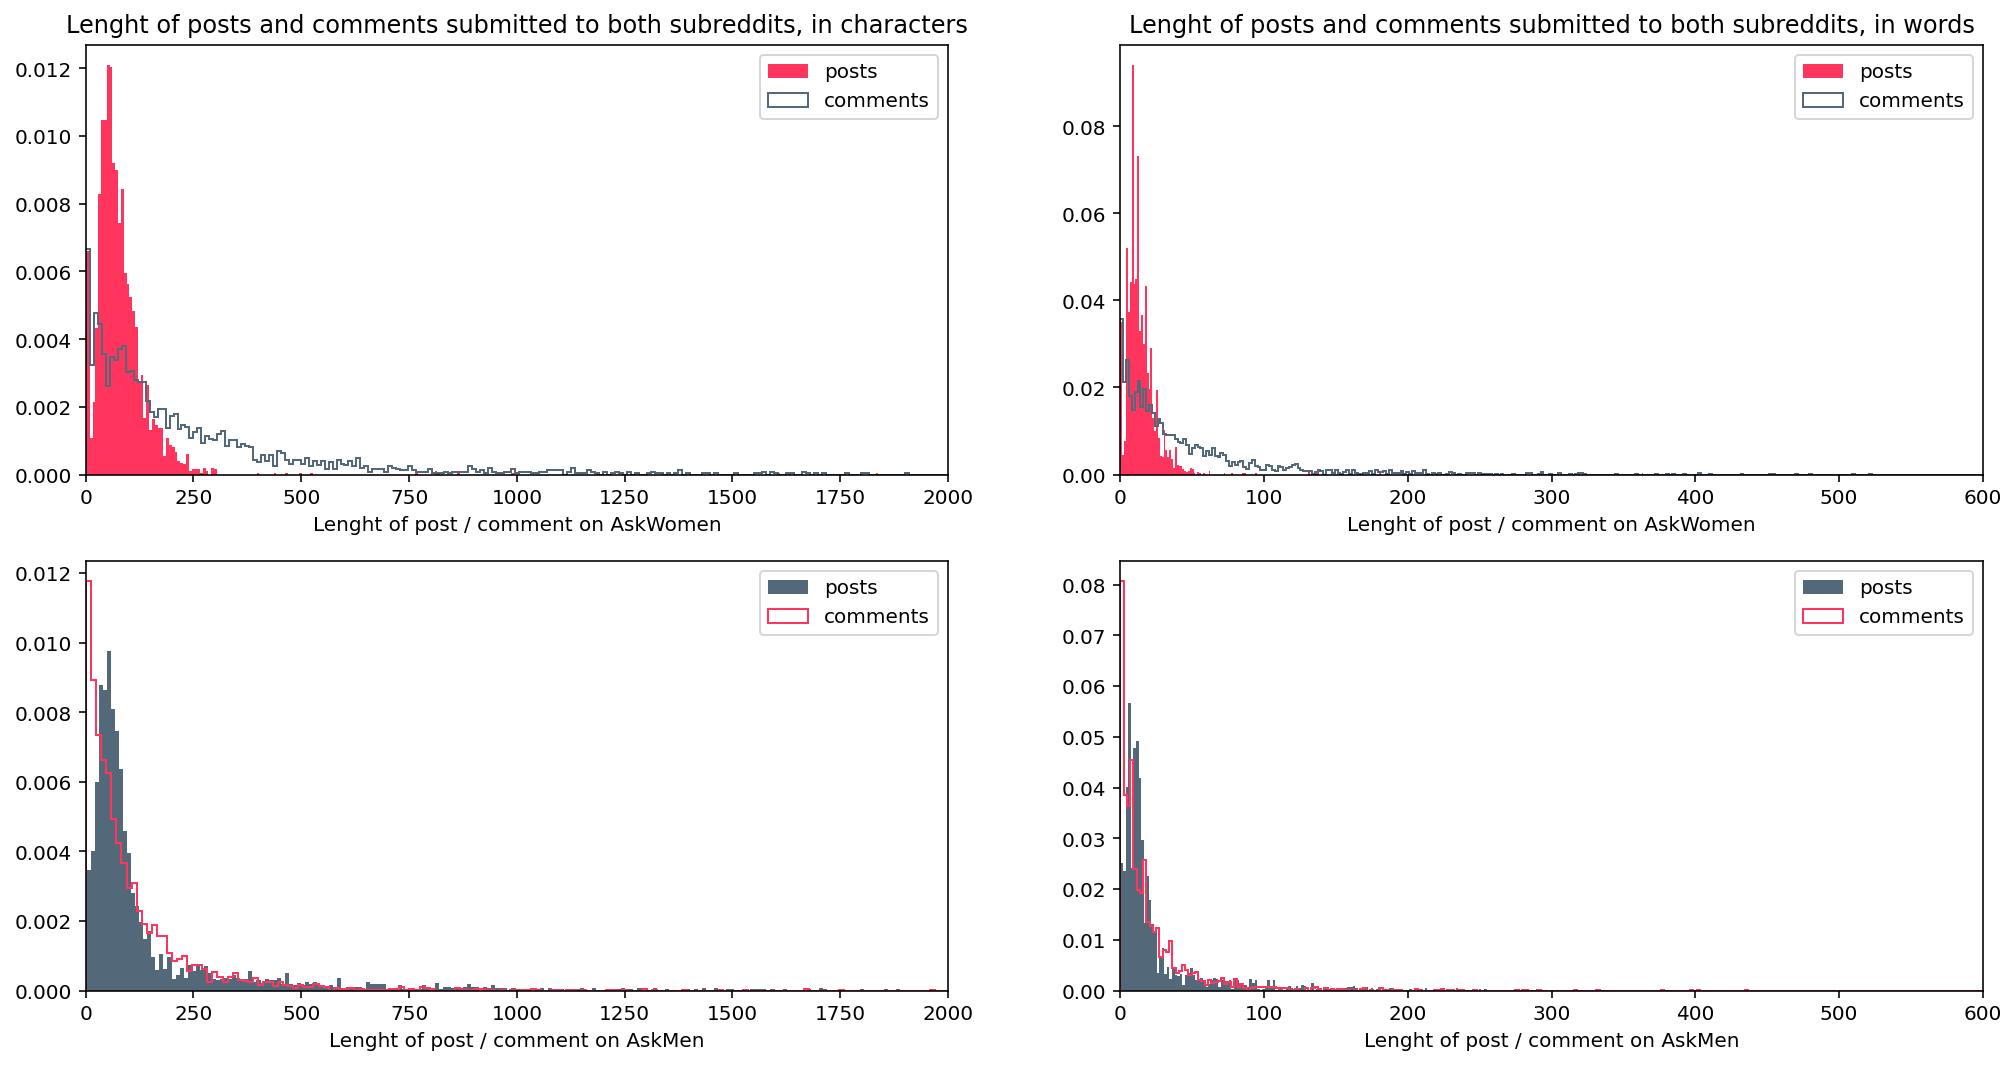

In [4]:
plt.figure(figsize = (17,9))
plt.subplot(2,2,1)
plt.title('Lenght of posts and comments submitted to both subreddits, in characters')
plt.hist(AW_posts_df['len_chars'], color = '#ff355e', label = 'posts', bins = 500, density = True)
plt.hist(AW_comments_df['len_chars'], color = '#536878', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,2000)
plt.xlabel('Lenght of post / comment on AskWomen')
plt.legend()
plt.subplot(2,2,3)
plt.hist(AM_posts_df['len_chars'], color = '#536878', label = 'posts', bins = 500, density = True)
plt.hist(AM_comments_df['len_chars'], color = '#ff355e', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,2000)
plt.xlabel('Lenght of post / comment on AskMen')
plt.legend()
plt.subplot(2,2,2)
plt.title('Lenght of posts and comments submitted to both subreddits, in words')
plt.hist(AW_posts_df['len_words'], color = '#ff355e', label = 'posts', bins = 500, density = True)
plt.hist(AW_comments_df['len_words'], color = '#536878', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,600)
plt.xlabel('Lenght of post / comment on AskWomen')
plt.legend()
plt.subplot(2,2,4)
plt.hist(AM_posts_df['len_words'], color = '#536878', label = 'posts', bins = 500, density = True)
plt.hist(AM_comments_df['len_words'], color = '#ff355e', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,600)
plt.xlabel('Lenght of post / comment on AskMen')
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15);
plt.savefig('../visualizations/lenghts.png')

### 3.2 Checking the timespan of harversted data

In [5]:
dfs = [AW_posts_df, AM_posts_df, AM_comments_df, AW_comments_df]
for df in dfs:
    df['created_yr'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).year)
    df['created_mth'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).month)
    df['created_dy'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).day)
    df['created_hr'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).hour)

In [6]:
#AM_posts_df[['created_yr', 'created_mth', 'created_dy']].describe()
AM_posts_df[['created_yr', 'created_mth', 'created_dy']].agg(['min', 'max'])

created_yr  created_mth  created_dy
min        2020           12          21
max        2020           12          28

_This would have maybe gone further but all the 9000+ entries are from just a few days in December, so it didn't seem interesting_

### 3.3 Analysis of vocabulary (incl. bigrams, trigrams, and emoji)

#### 3.3.1 Extending the list of stop words to include punctuation

In [7]:
stops = stopwords.words('english')
additions = ["!","?",".",":",";", ",", "\'", "\"","*", "'", '"', "[", ']', '(', ")", '’', '-', '...', '&', '|', '\”']
stops.extend(additions)

#### 3.3.2 Creating corpora and tokenized versions of AskWomen posts and comments and AskMen posts and comments

In [8]:
AW_comments_corpus = ''
for i in range(len(AW_comments_df)):
    AW_comments_corpus+=str(AW_comments_df.iloc[i,list(AW_comments_df.columns).index('body')])

AM_comments_corpus = ''
for i in range(len(AM_comments_df)):
    AM_comments_corpus+=str(AM_comments_df.iloc[i,list(AM_comments_df.columns).index('body')])

AW_posts_corpus = ''
for i in range(len(AW_posts_df)):
    AW_posts_corpus+=str(AW_posts_df.iloc[i,list(AW_posts_df.columns).index('title_selftext')])
    
AM_posts_corpus = ''
for i in range(len(AM_posts_df)):
    AM_posts_corpus+=str(AM_posts_df.iloc[i,list(AM_posts_df.columns).index('title_selftext')])

In [9]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
AM_tokens = word_tokenize(AM_posts_corpus.lower()+AM_comments_corpus.lower())
AM_stem_tokens = [stemmer.stem(token) for token in AM_tokens]
AM_stem_tokens_no_stops = [token for token in AM_stem_tokens if not token in stops]

In [10]:
AW_tokens = word_tokenize(AW_posts_corpus.lower()+AW_comments_corpus.lower())
AW_stem_tokens = [stemmer.stem(token) for token in AW_tokens]
AW_stem_tokens_no_stops = [token for token in AW_stem_tokens if not token in stops]

#### 3.3.3 Exploring most common words, bigrams, and trigrams

3.3.3.1 Word Analysis

In [11]:
AM_most_common_words = set([word for word, ct in FreqDist(AM_stem_tokens_no_stops).most_common(50)])
AW_most_common_words = set([word for word, ct in FreqDist(AW_stem_tokens_no_stops).most_common(50)])

AW_and_AM = set.union(AW_most_common_words, AM_most_common_words)

In [12]:
common_words = pd.DataFrame(np.array([list(AW_and_AM), [-FreqDist(AM_stem_tokens_no_stops)[word] for word in AW_and_AM],
                             [FreqDist(AW_stem_tokens_no_stops)[word] for word in AW_and_AM]]).T, 
                             columns = ['word', 'AM', 'AW'])

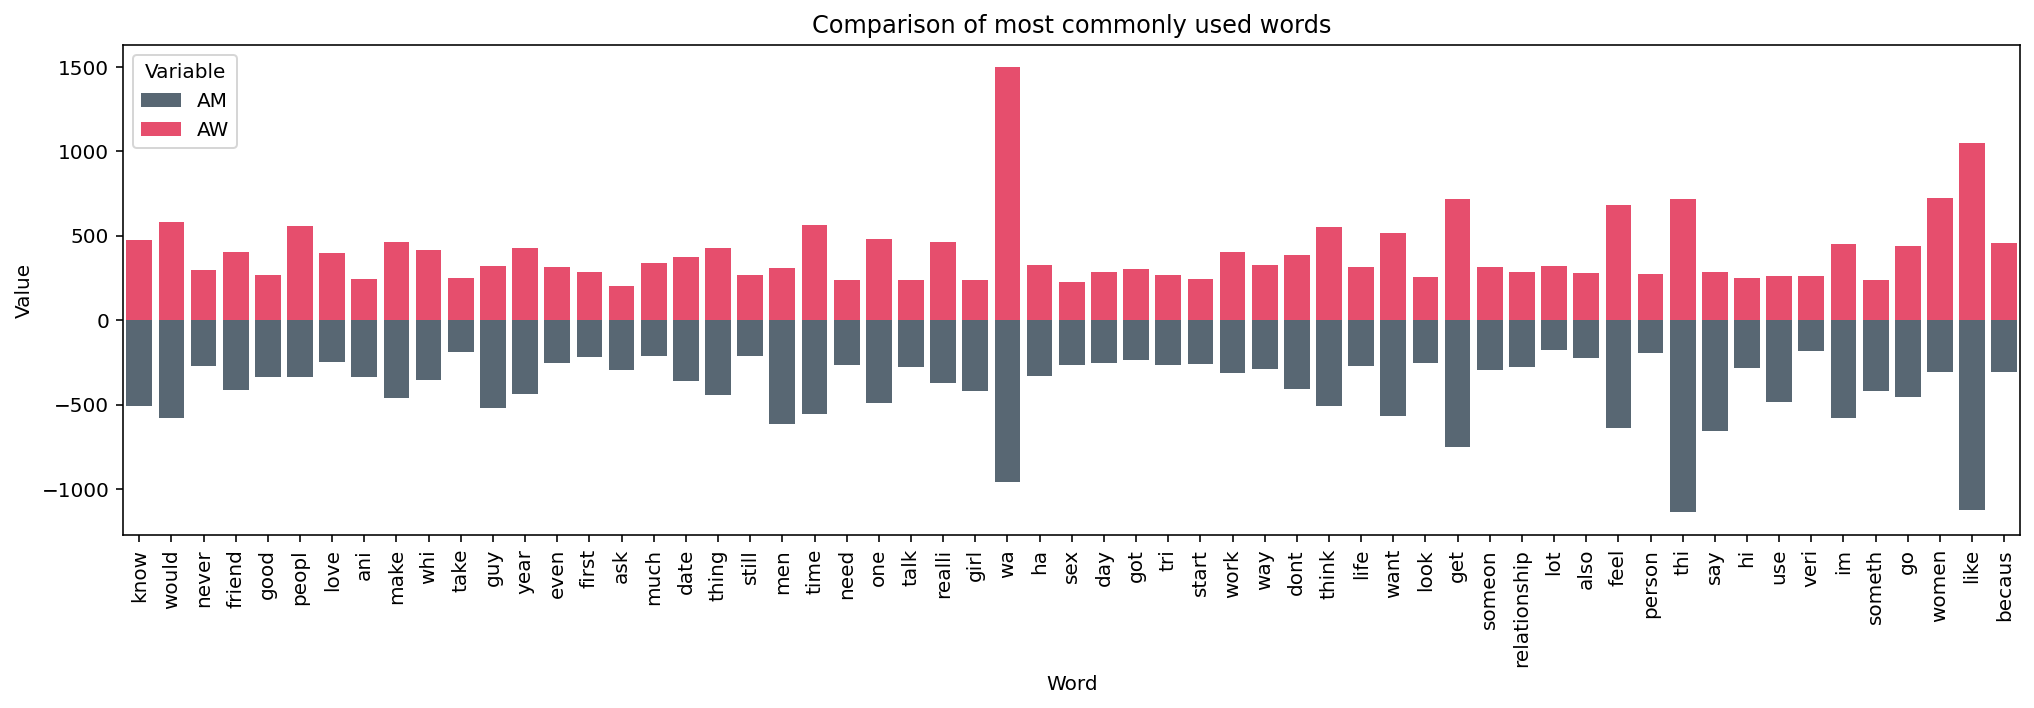

In [13]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_words.melt(id_vars='word').rename(columns=str.title)
sns.barplot(x='Word', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used words')
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.2);
plt.savefig('../visualizations/common_words.png')

In [14]:
AM_most_common_words.difference(AW_most_common_words)

{'ani', 'ask', 'girl', 'hi', 'need', 'sex', 'someth', 'start', 'talk'}

In [15]:
AW_most_common_words.difference(AM_most_common_words)

{'also', 'first', 'got', 'lot', 'much', 'person', 'still', 'take', 'veri'}

In [16]:
# this piece of code is adapted from https://github.com/JasonKessler/scattertext

text_subreddit = pd.concat([AW_posts_df[['title_selftext', 'subreddit']], AW_comments_df[['body', 'subreddit']], 
               AM_posts_df[['title_selftext', 'subreddit']], AM_comments_df[['body', 'subreddit']]], axis = 0)

text_subreddit['title_selftext'] = text_subreddit['title_selftext'].fillna("")
text_subreddit['body'] = text_subreddit['body'].fillna("")
text_subreddit['text'] = text_subreddit['title_selftext']+text_subreddit['body']

nlp = spacy.load('en_core_web_sm')
corpus = st.CorpusFromPandas(text_subreddit,
                              category_col='subreddit',
                              text_col='text',
                              nlp=nlp).build()

corpus_dataframe = text_subreddit
html = st.produce_scattertext_explorer(
                   corpus,
                   category='AskMen',
                   category_name='AskMen',
                   not_category_name='AskWomen',
                   width_in_pixels=1000)

In [17]:
display(HTML("<style>.container { width:98% !important; }</style>"))
display(HTML(html))

3.3.3.1 Analysis of bigrams and trigrams

In [18]:
AW_bigrams = list(ngrams(AW_stem_tokens_no_stops,2))
FreqDist(AW_bigrams)

FreqDist({('feel', 'like'): 143, ('women', 'reddit'): 88, ('first', 'date'): 58, ('last', 'name'): 52, ('thi', 'year'): 49, ('make', 'feel'): 48, ('everi', 'day'): 44, ('best', 'friend'): 44, ('year', 'old'): 43, ('dont', 'know'): 41, ...})

In [19]:
AM_bigrams = list(ngrams(AM_stem_tokens_no_stops,2))
FreqDist(AM_bigrams)

FreqDist({('feel', 'like'): 146, ('men', 'reddit'): 107, ('year', 'old'): 80, ('dont', 'know'): 69, ('gon', 'na'): 53, ('wan', 'na'): 50, ('like', 'thi'): 48, ('thi', 'year'): 46, ('dont', 'want'): 42, ('first', 'date'): 40, ...})

In [20]:
AM_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,2)).most_common(40)])
AW_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,2)).most_common(40)])

AW_and_AM_bi = set.union(AW_most_common_bi, AM_most_common_bi)

In [21]:
common_bis = pd.DataFrame(np.array([list(AW_and_AM_bi), 
                            [-FreqDist(ngrams(AM_stem_tokens_no_stops,2))[bi] for bi in AW_and_AM_bi],
                            [FreqDist(ngrams(AW_stem_tokens_no_stops,2))[bi] for bi in AW_and_AM_bi]]).T, 
                             columns = ['bigram', 'AM', 'AW'])

<ipython-input-21-03db1970efd8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_bis = pd.DataFrame(np.array([list(AW_and_AM_bi),


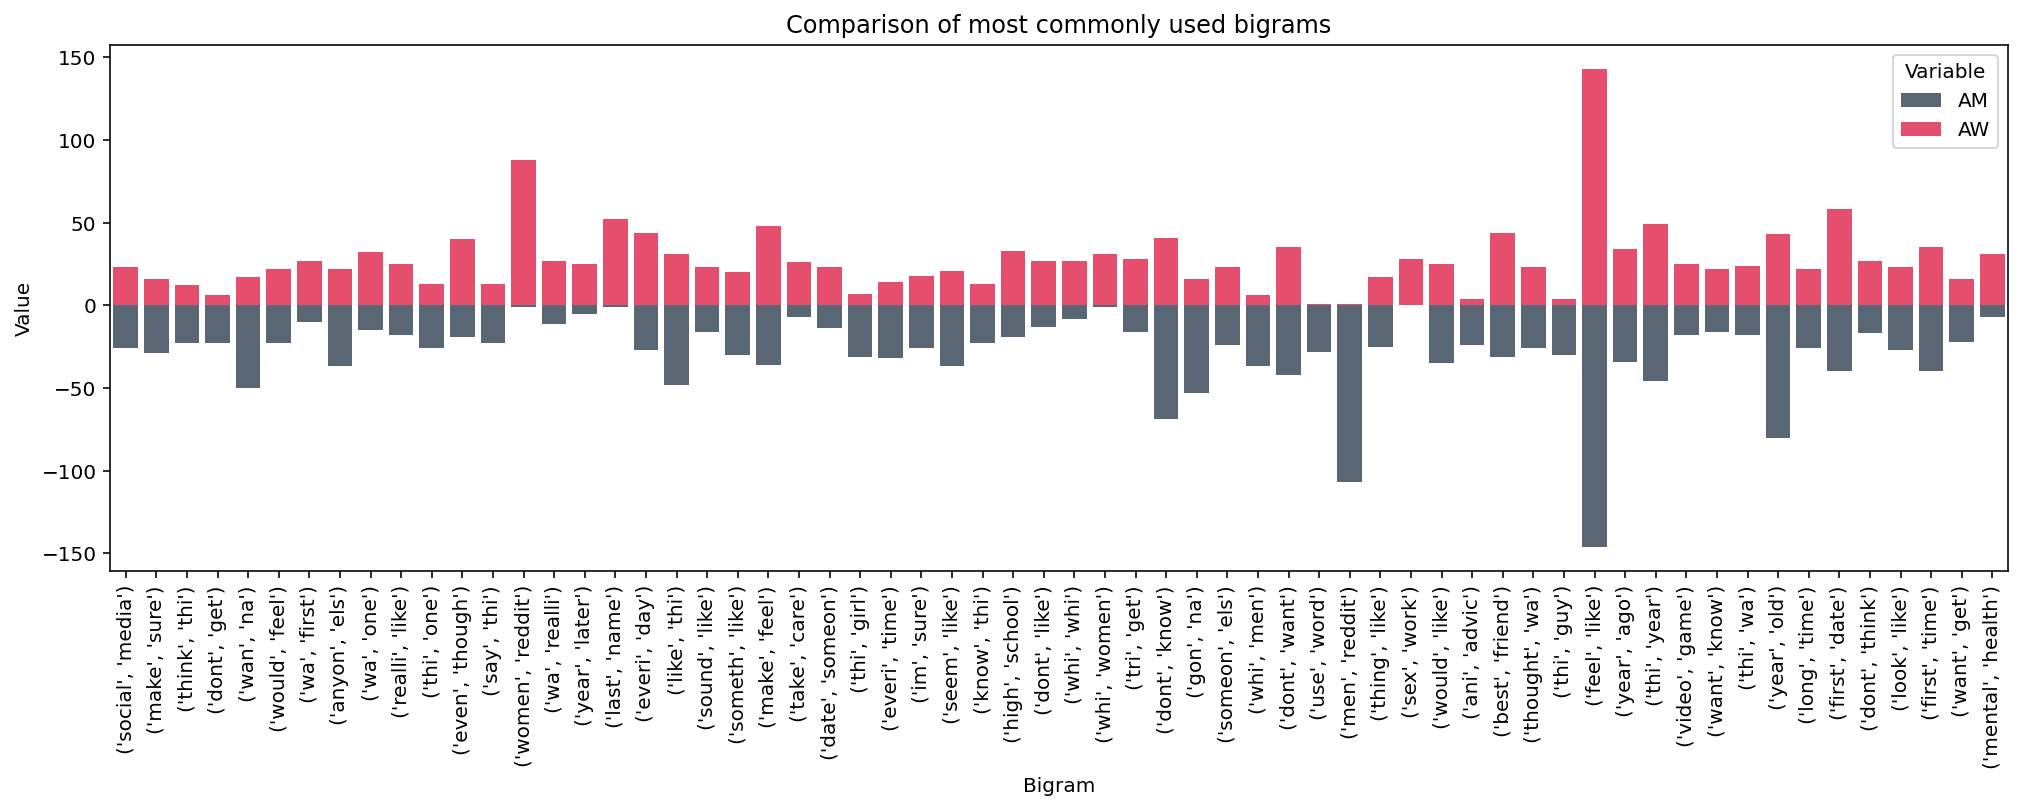

In [22]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_bis.melt(id_vars='bigram').rename(columns=str.title)
sns.barplot(x='Bigram', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used bigrams')
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.15);
plt.savefig('../visualizations/common_bigrams.png')

In [23]:
AW_trigrams = list(ngrams(AW_stem_tokens_no_stops,3)) #AW_stem_tokens_no_stops
FreqDist(AW_trigrams)

FreqDist({('first', 'date', 'wa'): 19, ('play', 'video', 'game'): 11, ('long', 'term', 'relationship'): 9, ('feel', 'like', 'im'): 9, ('talk', 'neg', 'women'): 7, ('chang', 'last', 'name'): 7, ('got', 'back', 'togeth'): 7, ('feel', 'thi', 'way'): 6, ('full', 'time', 'job'): 6, ('told', 'ex', 'worri'): 6, ...})

In [24]:
AM_trigrams = list(ngrams(AM_stem_tokens_no_stops,3))
FreqDist(AM_trigrams)

FreqDist({('amp', '#', 'xb'): 14, ('play', 'video', 'game'): 11, ('ai', 'dungeon', 'sexi'): 10, ('dungeon', 'sexi', 'funni'): 10, ('sexi', 'funni', 'one'): 10, ('funni', 'one', 'base'): 10, ('one', 'base', 'wholli'): 10, ('base', 'wholli', 'reddit'): 10, ('sex', 'first', 'date'): 10, ('year', 'old', 'dad'): 10, ...})

In [25]:
AM_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,3)).most_common(40)])
AW_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,3)).most_common(40)])

AW_and_AM_tri = set.union(AW_most_common_tri, AM_most_common_tri)

In [26]:
common_tris = pd.DataFrame(np.array([list(AW_and_AM_tri), 
                                     [-FreqDist(ngrams(AM_stem_tokens_no_stops,3))[tri] for tri in AW_and_AM_tri],
                                      [FreqDist(ngrams(AW_stem_tokens_no_stops,3))[tri] for tri in AW_and_AM_tri]]).T, 
                                     columns = ['trigram', 'AM', 'AW'])

<ipython-input-26-52334ec0766e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_tris = pd.DataFrame(np.array([list(AW_and_AM_tri),


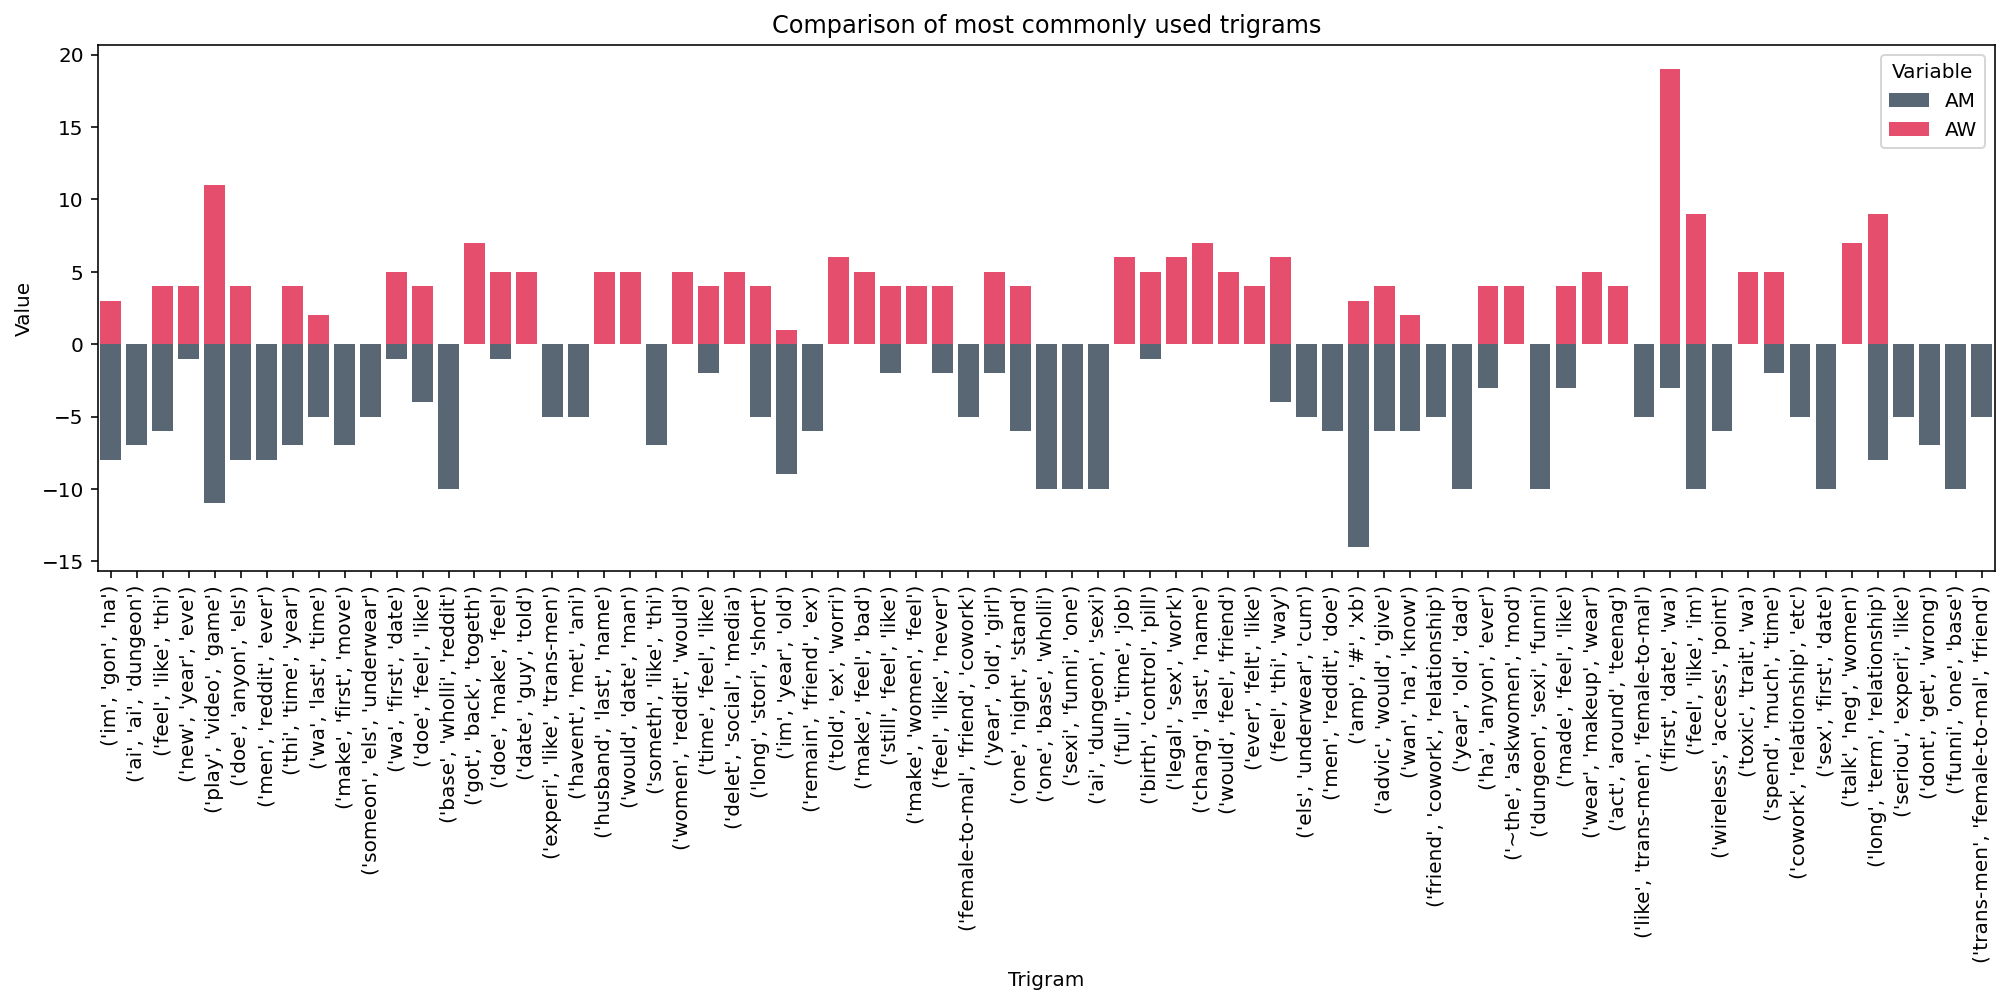

In [27]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_tris.melt(id_vars='trigram').rename(columns=str.title)
sns.barplot(x='Trigram', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used trigrams')
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.15);
plt.savefig('../visualizations/common_trigrams.png')

In [28]:
AW_vocabulary = sorted(list(set((AW_posts_corpus+AW_comments_corpus).lower().split())))
AM_vocabulary = sorted(list(set((AM_posts_corpus+AM_comments_corpus).lower().split())))

print("=========AskMen=========")
print(len(AM_vocabulary))
print("\n========AskWomen========")
print(len(AW_vocabulary))

=========AskMen=========
20547

========AskWomen========
20418


#### 3.3.4 Assessing use of emoji by contributors to AskWomen and AskMen

In [29]:
def extract_emojis(s):
  return [c for c in s if c in emoji.UNICODE_EMOJI]

In [30]:
AW_emojis = set(extract_emojis(AW_posts_corpus+AW_comments_corpus))
AM_emojis = set(extract_emojis(AM_posts_corpus+AM_comments_corpus))

In [31]:
print(f"AskWomen posts and comments feature {len(AW_emojis)} emojis: {AW_emojis}")

AskWomen posts and comments feature 67 emojis: {'🎄', '🤭', '✋', '💚', '💁', '👁', '🏻', '🎁', '😁', '😆', '👀', '🐱', '😔', '🏿', '💦', '😭', '🤢', '🥺', '❤', '🏼', '💍', '💗', '👰', '🤥', '🔥', '🤔', '🤷', '💕', '🥰', '😋', '😜', '👏', '😂', '❓', '🙄', '😢', '👇', '😌', '😬', '🎅', '☺', '🙂', '🙃', '😘', '🗨', '🤦', '🥴', '😳', '😍', '✨', '🤣', '😯', '😎', '😟', '🌚', '😊', '💛', '🏾', '💥', '〰', '🤡', '♥', '♀', '🙏', '😱', '💖', '😅'}


In [32]:
print(f"AskMen posts and comments feature {len(AM_emojis)} emojis: {AM_emojis}")

AskMen posts and comments feature 175 emojis: {'🏻', '👀', '📅', '🤪', '👥', '📒', '🏼', '❔', '🤷', '🤔', '🏃', '🙇', '💕', '😝', '👋', '👏', '😩', '😀', '💔', '👇', '😤', '👩', '😬', '👧', '🚬', '🤣', '🎤', '✅', '😠', '🎼', '🇦', '🤡', '🧠', '🤠', '👣', '🏽', '🤚', '😈', '🌪', '🍻', '📖', '🌄', '☝', '😁', '✔', '👻', '😔', '🏿', '👌', '😭', '📦', '😏', '❤', '🏘', '🙌', '🔥', '🌟', '🤫', '🏳', '✊', '😜', '🚫', '🇵', '❄', '❓', '🤜', '🙄', '😢', '👭', '🐰', '🔚', '💼', '🔍', '😊', '💬', '🚴', '🏾', '🚡', '♀', '🔁', '👱', '👫', '🕺', '👅', '💰', '🏄', '🏫', '🗣', '💹', '😆', '👪', '👵', '🔔', '🚑', '🎣', '💦', '🐝', '💯', '🙀', '💓', '💅', '👨', '🔫', '🏊', '🤽', '💪', '🌎', '🍓', '😂', '⚰', '📆', '👑', '🚶', '🙅', '❌', '😎', '✨', '📼', '💨', '💀', '🛑', '😓', '🍂', '🐾', '🎄', '✋', '☀', '🉐', '🍆', '👁', '😐', '💩', '🧐', '👶', '🌬', '♂', '😄', '📷', '🌙', '😃', '🥶', '👦', '🚯', '🐣', '👬', '🕛', '❎', '🌭', '🌾', '👍', '🧔', '🌹', '👊', '🚨', '🍑', '😌', '👴', '📝', '👈', '🌞', '😳', '🔗', '😯', '👉', '💢', '💥', '🤞', '🌈', '😮', '⬆', '😒', '🙏', '😱', '⏰', '🙈'}


In [33]:
AM_emojis_freq = {emo: (AM_posts_corpus+AM_comments_corpus).count(emo) for emo in AM_emojis}
AW_emojis_freq = {emo: (AW_posts_corpus+AW_comments_corpus).count(emo) for emo in AW_emojis}
emos = list(set([emo for emo in AM_emojis_freq.keys() if AM_emojis_freq[emo]>= 3]+[emo for emo in AW_emojis_freq.keys() if AW_emojis_freq[emo]>= 3]))

In [34]:
emos_chart = pd.DataFrame(np.array([[emoji.UNICODE_EMOJI[emo] for emo in emos], 
                                    [-AM_emojis_freq.setdefault(emo,0) for emo in emos],
                                     [AW_emojis_freq.setdefault(emo,0) for emo in emos]]).T, 
                                     columns = ['descr', 'AM', 'AW'])

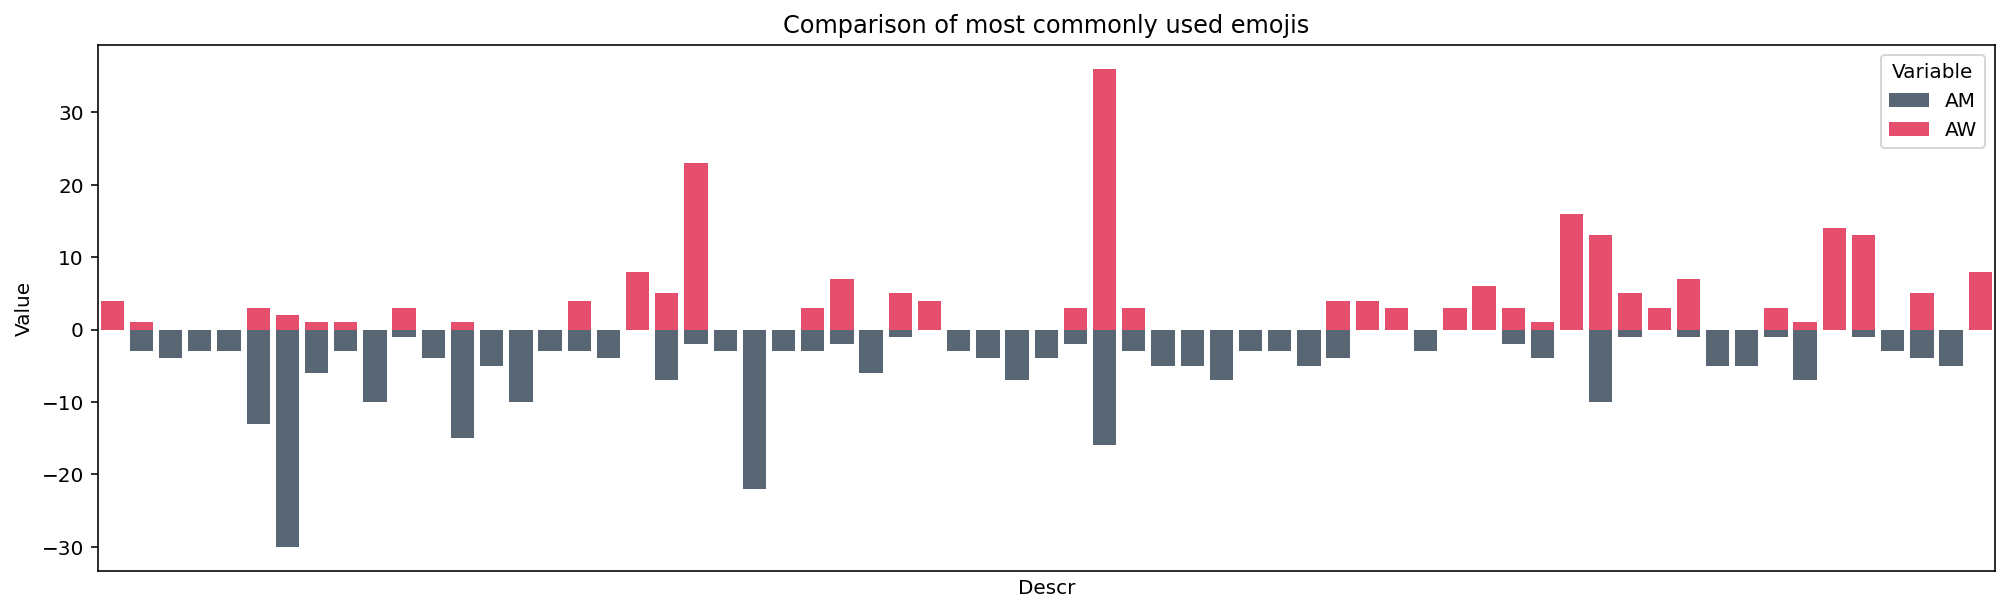

In [35]:
from matplotlib.font_manager import FontProperties
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = emos_chart.melt(id_vars='descr').rename(columns=str.title)
sns.barplot(x='Descr', y='Value', hue='Variable', data=tidy,  dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used emojis')
plt.xticks([])
plt.gcf().subplots_adjust(bottom=0.15);
plt.savefig('../visualizations/common_emojis.png')

In [36]:
#clean line for chart in presentation
"".join(emos)

'🤭✋🍆🏫🗣🏻👁👀😔♂🏿👌💦👥💯🙀😭👦🥺🏼❤👬👨🙌🤔🤷👍💕🥰🔫💪🚫👊👏😂🙄🚶😩😀🙅🐰❌😌🙂☺👈😘🤦😳😎😍🤣😯🌚😊💨👉🏾💥♥♀🔁🙏😈😅'

In [37]:
AW_posts_df['emojis'] = AW_posts_df['title_selftext'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AM_posts_df['emojis'] = AM_posts_df['title_selftext'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AW_comments_df['emojis'] = AW_comments_df['body'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AM_comments_df['emojis'] = AM_comments_df['body'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))

In [38]:
AW_posts_df['emojis'].agg(['min','mean', 'max', 'sum'])

min      0.000
mean     0.017
max      6.000
sum     51.000
Name: emojis, dtype: float64

In [39]:
AM_posts_df['emojis'].agg(['min','mean', 'max', 'sum'])

min      0.00
mean     0.01
max     10.00
sum     29.00
Name: emojis, dtype: float64

In [40]:
AW_comments_df['emojis'].agg(['min','mean', 'max', 'sum'])

min       0.000000
mean      0.081937
max      23.000000
sum     220.000000
Name: emojis, dtype: float64

In [41]:
AM_comments_df['emojis'].agg(['min','mean', 'max', 'sum'])

min       0.000000
mean      0.139266
max     343.000000
sum     410.000000
Name: emojis, dtype: float64

### 3.4 Sentiment Analysis

#### 3.4.1 Sentiment Analysis using nltk's Sentiment Intensity Analyzer

In [42]:
sia = SentimentIntensityAnalyzer()

In [43]:
AW_posts_df['sia_neg'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AW_posts_df['sia_neu'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AW_posts_df['sia_pos'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['pos'])
AM_posts_df['sia_neg'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AM_posts_df['sia_neu'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AM_posts_df['sia_pos'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

AW_comments_df['sia_neg'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AW_comments_df['sia_neu'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AW_comments_df['sia_pos'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['pos'])
AM_comments_df['sia_neg'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AM_comments_df['sia_neu'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AM_comments_df['sia_pos'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

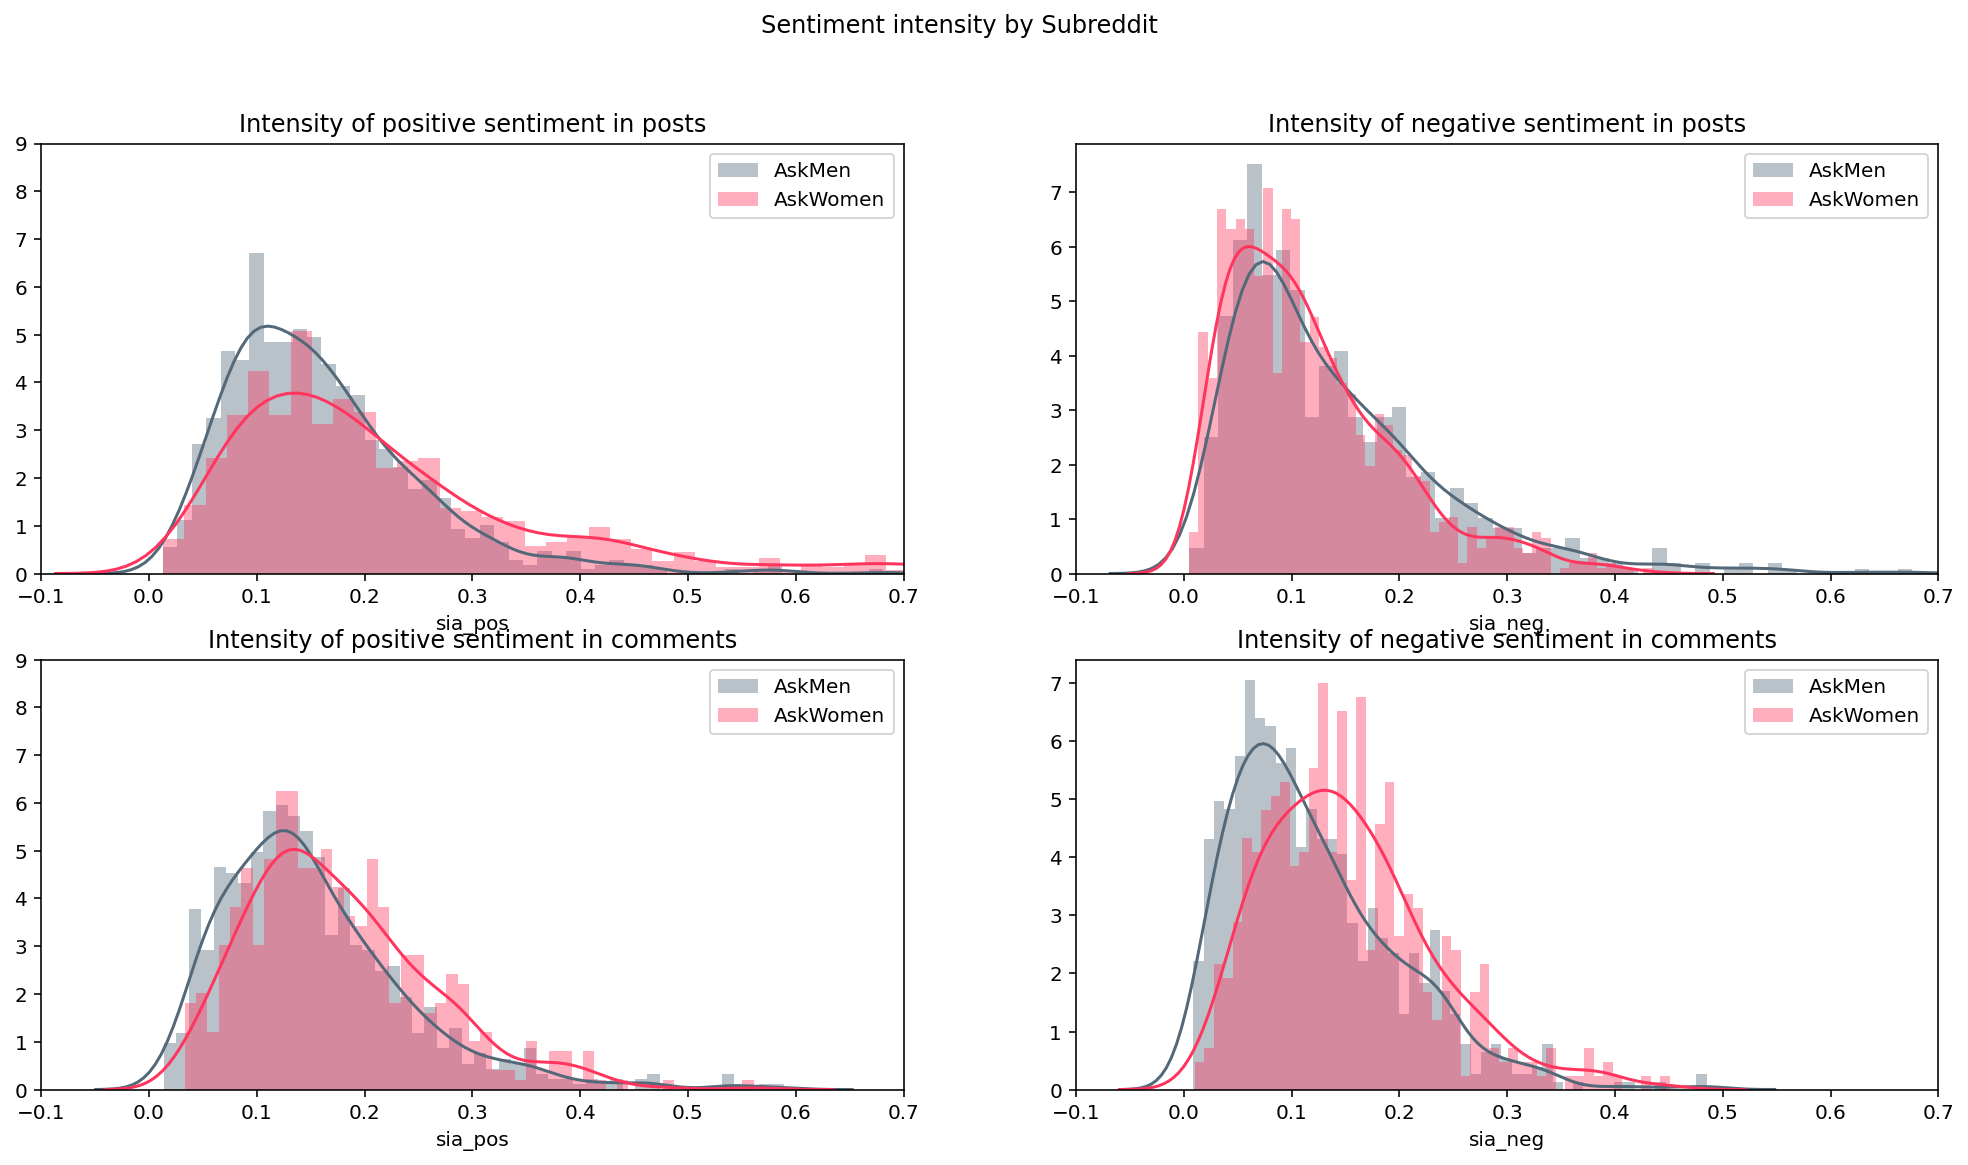

In [44]:
plt.figure(figsize = (17,9))

plt.suptitle('Sentiment intensity by Subreddit')
plt.subplot(2,2,1)
plt.title('Intensity of positive sentiment in posts')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AM_comments_df['sia_neg']!=0)]['sia_pos'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AW_comments_df['sia_neg']!=0)]['sia_pos'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.ylim(0,9)
plt.subplot(2,2,2)
plt.title('Intensity of negative sentiment in posts')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AM_comments_df['sia_neg']!=0)]['sia_neg'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_comments_df[(AW_comments_df['sia_pos']!=0) & (AW_comments_df['sia_neg']!=0)]['sia_neg'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.subplot(2,2,3)
plt.title('Intensity of positive sentiment in comments')
sns.distplot(AM_posts_df[(AM_posts_df['sia_pos']!=0) & (AM_posts_df['sia_neg']!=0)]['sia_pos'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_posts_df[(AW_posts_df['sia_pos']!=0) & (AW_posts_df['sia_neg']!=0)]['sia_pos'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.ylim(0,9)
plt.subplot(2,2,4)
plt.title('Intensity of negative sentiment in comments')
sns.distplot(AM_posts_df[(AM_posts_df['sia_pos']!=0) & (AM_posts_df['sia_neg']!=0)]['sia_neg'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_posts_df[(AW_posts_df['sia_pos']!=0) & (AW_posts_df['sia_neg']!=0)]['sia_neg'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.gcf().subplots_adjust(bottom=0.15);

plt.savefig('../visualizations/sent_intensity.png')

#### 3.4.2 Sentiment Analysis using HuggingFace's Sentiment Analysis transformer

In [45]:
senti = pipeline('sentiment-analysis')

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['pre_classifier', 'classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-b

In [46]:
AW_posts_df['senti_pn'] = AW_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AW_posts_df['senti_score'] = AW_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [47]:
AM_posts_df['senti_pn'] = AM_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AM_posts_df['senti_score'] = AM_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [48]:
AW_comments_df['senti_pn'] = AW_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AW_comments_df['senti_score'] = AW_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [49]:
AM_comments_df['senti_pn'] = AM_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AM_comments_df['senti_score'] = AM_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [50]:
print(f"{round(len(AW_posts_df[AW_posts_df['senti_pn'] == 'POSITIVE'])/len(AW_posts_df),4)*100}% of posts on AskWomen are categorized as positive.")
print(f"{round(len(AM_posts_df[AM_posts_df['senti_pn'] == 'POSITIVE'])/len(AM_posts_df),4)*100}% of posts on AskMen are categorized as positive.")
print(f"{round(len(AW_posts_df[AW_posts_df['senti_pn'] == 'NEGATIVE'])/len(AW_posts_df),4)*100}% of comments on AskWomen are categorized as negative.")
print(f"{round(len(AM_posts_df[AM_posts_df['senti_pn'] == 'NEGATIVE'])/len(AM_posts_df),4)*100}% of comments on AskMen are categorized as negative.")

24.9% of posts on AskWomen are categorized as positive.
23.52% of posts on AskMen are categorized as positive.
75.1% of comments on AskWomen are categorized as negative.
76.48% of comments on AskMen are categorized as negative.


In [51]:
AM_posts_df['senti_score'].fillna(0, inplace = True)
AM_comments_df['senti_score'].fillna(0, inplace = True)
AW_posts_df['senti_score'].fillna(0, inplace = True)
AW_comments_df['senti_score'].fillna(0, inplace = True)

In [52]:
AM_posts_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AM_comments_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AW_posts_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AW_comments_df['senti_pn'].fillna('NEUTRAL', inplace = True)

In [53]:
AW_posts_df['senti_pn_bin'] = AW_posts_df['senti_pn'].map({'POSITIVE': 1, 'NEGATIVE': 0})
AW_comments_df['senti_pn_bin'] = AW_comments_df['senti_pn'].map({'POSITIVE': 1, 'NEGATIVE': 0})
AM_posts_df['senti_pn_bin'] = AM_posts_df['senti_pn'].map({'POSITIVE': 1, 'NEGATIVE': 0})
AM_comments_df['senti_pn_bin'] = AM_comments_df['senti_pn'].map({'POSITIVE': 1, 'NEGATIVE': 0})

In [54]:
AM_posts_df['senti_score'].fillna(0, inplace = True)
AM_comments_df['senti_score'].fillna(0, inplace = True)
AW_posts_df['senti_score'].fillna(0, inplace = True)
AW_comments_df['senti_score'].fillna(0, inplace = True)

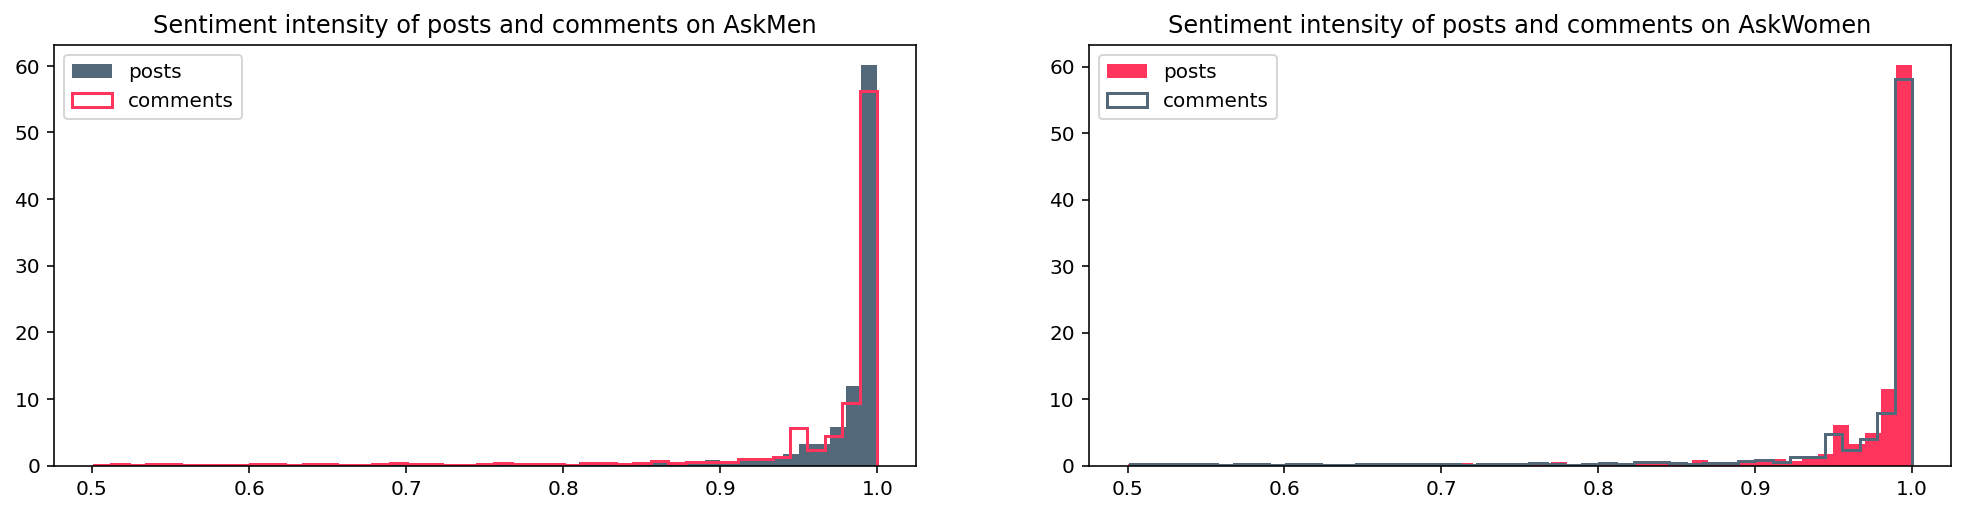

In [55]:
plt.figure(figsize = (17,4))
plt.subplot(1,2,1)
plt.hist(AM_posts_df['senti_score'], density = True, bins = 50, color = '#536878', label = 'posts')
plt.hist(AM_comments_df['senti_score'], density = True, bins = 45, color = '#ff355e', histtype= 'step', lw = 1.5, label = 'comments')
plt.legend()
plt.title('Sentiment intensity of posts and comments on AskMen')
plt.subplot(1,2,2)
plt.hist(AW_posts_df['senti_score'], density = True, bins = 50, color = '#ff355e', label = 'posts')
plt.hist(AW_comments_df['senti_score'], density = True, bins = 45, color = '#536878', histtype= 'step', lw = 1.5, label = 'comments')
plt.legend()
plt.title('Sentiment intensity of posts and comments on AskWomen')
plt.gcf().subplots_adjust(bottom=0.15);
plt.savefig('../visualizations/senti.png')

#### Exporting enhanced data to csv files for retrieval in subsequent parts

In [56]:
AW_comments_df.to_csv('../data/aw_com.csv')
AW_posts_df.to_csv('../data/aw_pos.csv')
AM_comments_df.to_csv('../data/am_com.csv')
AM_posts_df.to_csv('../data/am_pos.csv')